<a href="https://githubtocolab.com/Astolfo2332/Biosenales_el_regreso/blob/main/Proyecto_3_los_4GB.ipynb"
    target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" /></a>

# Proyecto 3

4 GB de audio no es nada

## Descarga de Kaggel

Aqui mete el json de kaggle

In [ ]:
from google.colab import files

files.upload()


In [ ]:
!mkdir - p ~/.kaggle
!cp kaggle.json ~/.kaggle/
'chmod 600 /root/.kaggle/kaggle.json'  # Para proteger la información


In [ ]:
!kaggle datasets download -d vbookshelf/respiratory-sound-database
! unzip respiratory-sound-database.zip


La mousque herramienta misteriosa

In [ ]:
!wget https://raw.githubusercontent.com/Astolfo2332/Biosenales_el_regreso/main/special_fun.py


# 1 El análisis

In [101]:
import os
import winsound
import special_fun as s
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal as signal
import pywt
from scipy.signal import firwin
#Para que me avise
duration = 1000 
freq = 440 

## 1.1 Carga

In [2]:
ruta_carpeta = './Data/audio_and_txt_files'
#Si es en colab
#ruta_carpeta = "/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files" 
lista_archivos = os.listdir(ruta_carpeta)
datos_sano,datos_crepitancia,datos_silbancia=s.el_discriminador(lista_archivos,ruta_carpeta)

In [3]:
print("Pacientes con ciclos sanos: ",len(datos_sano))
print("Pacientes con ciclos silbancias: ",len(datos_crepitancia))
print("Pacientes con ciclos crepitancias: ",len(datos_silbancia))

Pacientes con ciclos sanos:  714
Pacientes con ciclos silbancias:  499
Pacientes con ciclos crepitancias:  336


## Obtención de los audios

In [4]:
datos=s.sonido_probando123(lista_archivos,ruta_carpeta)

## Ejemplo del metodo usado

En este caso tomaremos un dato en particular para mostrar el proceso

In [63]:
y,sr=librosa.load(list(datos.keys())[20])

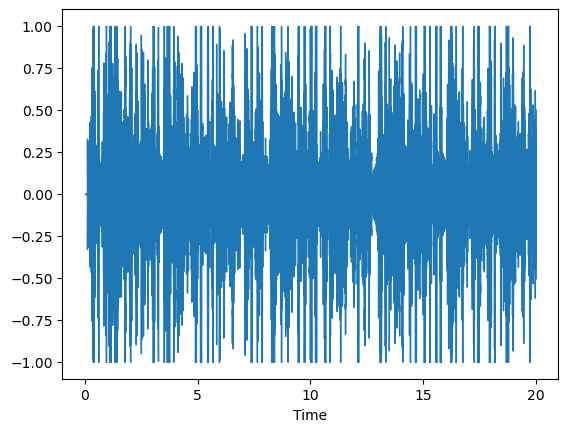

In [7]:
librosa.display.waveshow(y,sr=sr)

Creamos los filtros:

In [8]:
high=100
low=2000
nyq=sr/2
N_hp=int((5*nyq)/high)
N_lp=int((5*nyq)/low)
if N_hp%2==0:
    N_hp+=1
if N_lp%2==0:
    N_lp+=1
low_pass=firwin(N_lp, low/nyq ,window=('kaiser',7.85))
high_pass=firwin(N_hp, high/nyq ,pass_zero="highpass",window=('kaiser',7.85))

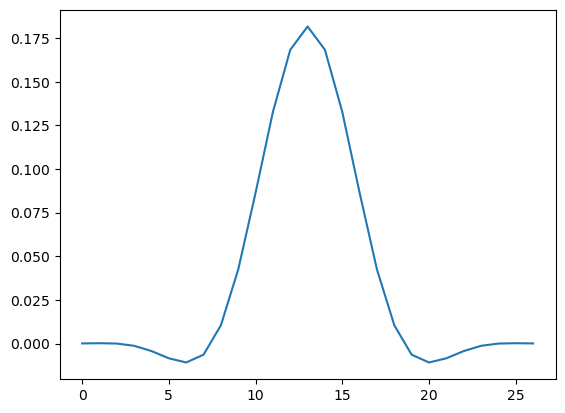

In [9]:
plt.plot(low_pass)

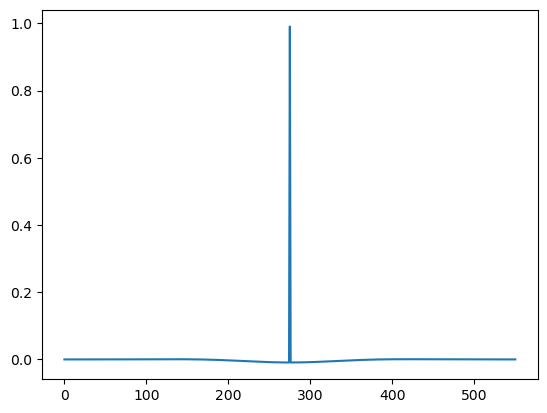

In [10]:
plt.plot(high_pass)

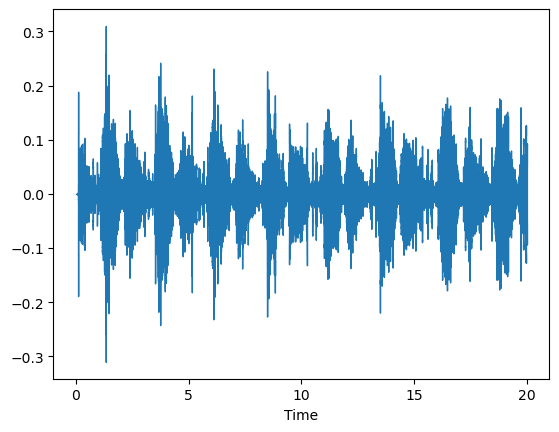

In [11]:
y_h = signal.filtfilt(high_pass, 1, y)
y_l = signal.filtfilt(low_pass, 1, y_h)
y = np.asfortranarray(y_l)
librosa.display.waveshow(y_h,sr=sr)

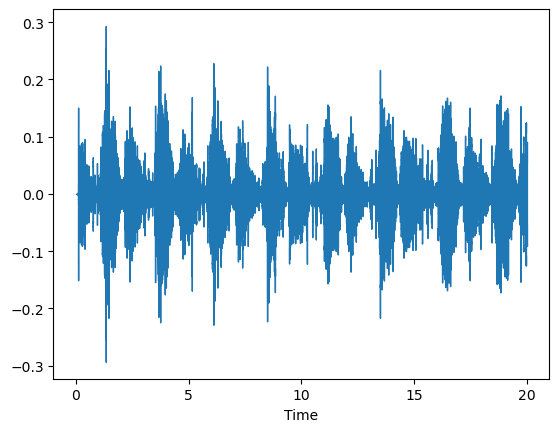

In [12]:
librosa.display.waveshow(y_l,sr=sr)

In [13]:
data_wavelet = pywt.wavedec( y_l, 'db6', level=8 )  
details = data_wavelet[1:]
details_t = s.wthresh(details)
rec=list()
rec.append(data_wavelet[0])
for i in range(len(details_t)): 
    rec.append(details_t[i]) 
x_rec = pywt.waverec( rec, 'db6') 
x_rec = x_rec[0:y.shape[0]]
y_fil=np.squeeze(y - x_rec)

La discriminación de los ciclos cardíacos

Text(0.5, 1.0, 'Discriminación ciclos cardíacos')

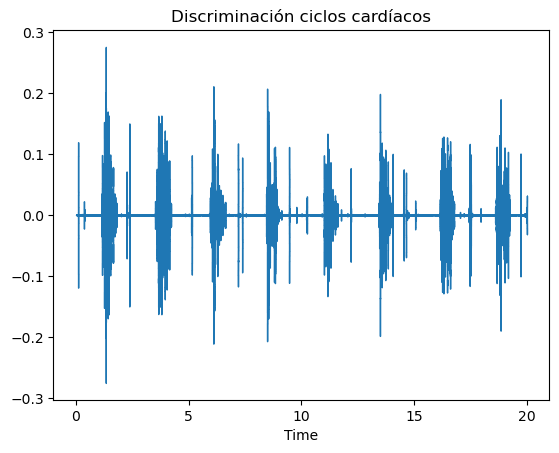

In [14]:
librosa.display.waveshow(x_rec,sr=sr)
plt.title("Discriminación ciclos cardíacos")

Text(0.5, 1.0, 'Señal filtrada')

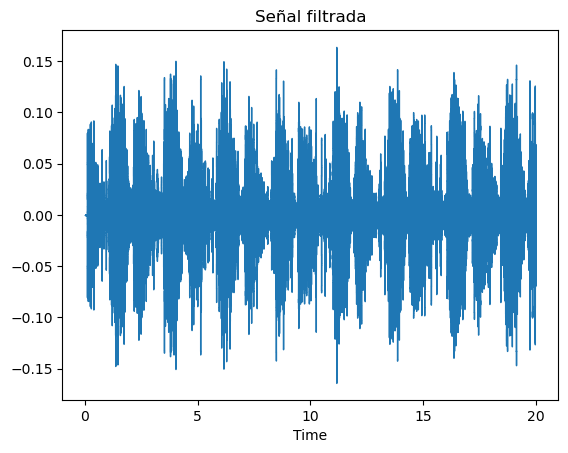

In [15]:
librosa.display.waveshow(y_fil,sr=sr)
plt.title("Señal filtrada")

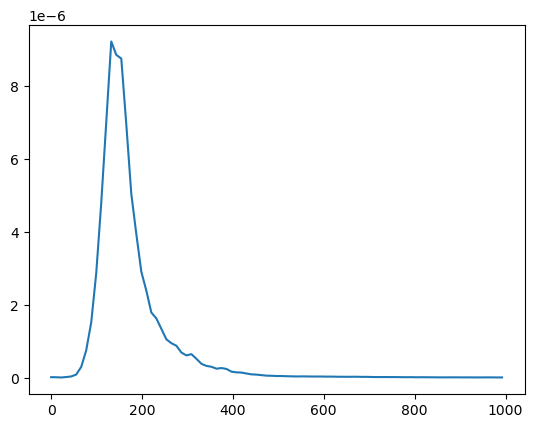

In [16]:
f,Pxx=signal.welch(y_fil,sr,"hamming",2000,1000,scaling="density")
r=f<1000
plt.plot(f[r],Pxx[r])

# Generación de espectros

In [180]:
def custom_filter(fs,low=2000,high=100):
    nyq=fs/2
    #N_hp=int((5*nyq)/high)
    #N_lp=int((5*nyq)/low)
    N_hp=int((3.3*nyq)/high)
    N_lp=int((3.3*nyq)/low)
    if N_hp%2==0:
        N_hp+=1
    if N_lp%2==0:
        N_lp+=1
    #low_pass=firwin(N_lp, low/nyq ,window=('kaiser',7.85),pass_zero="lowpass")
    #high_pass=firwin(N_hp, high/nyq ,pass_zero="highpass",window=('kaiser',7.85))
    low_pass=firwin(N_lp, low/nyq ,window="hamming",pass_zero="lowpass")
    high_pass=firwin(N_hp, high/nyq ,pass_zero="highpass",window="hamming")
    return low_pass,high_pass

In [181]:
low_pass,high_pass=custom_filter(datos[list(datos.keys())[0]][1])

In [28]:
def el_filtrador(data,low_pass,high_pass,nivel=10):
    y_h = signal.filtfilt(high_pass, 1, data)
    y_l = signal.filtfilt(low_pass, 1, y_h)
    y = np.asfortranarray(y_l)
    data_wavelet = pywt.wavedec( y_l, 'db6', level=nivel )  
    details = data_wavelet[1:]
    details_t = s.wthresh(details)
    rec=list()
    rec.append(data_wavelet[0])
    for i in range(len(details_t)): 
        rec.append(details_t[i]) 
    x_rec = pywt.waverec( rec, 'db6') 
    x_rec = x_rec[0:y.shape[0]]
    y_fil=np.squeeze(y - x_rec)
    return y_fil

In [33]:
def filtrar_todo(datos,low_pass,high_pass,level=10):
    fil={}
    for i in list(datos.keys()):
        y_fil=el_filtrador(datos[i][0],low_pass,high_pass,nivel=10)
        fil[i]=y_fil
    return fil

In [182]:
fil=filtrar_todo(datos,low_pass,high_pass,8)
winsound.Beep(freq, duration)

(0.0, 20000.0)

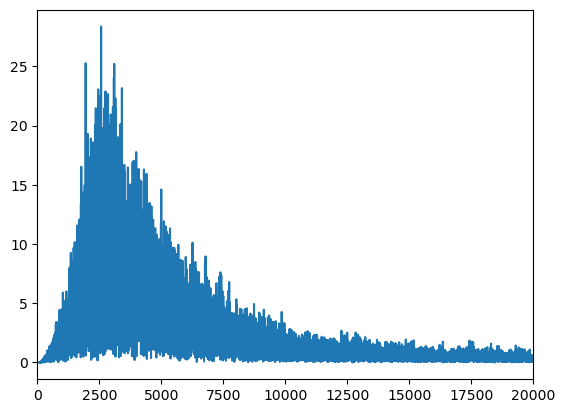

In [175]:
plt.plot(np.abs(np.fft.fft(fil['./Data/audio_and_txt_files\\101_1b1_Al_sc_Meditron.wav'])))
plt.xlim([0,20000])

In [152]:
def welch_a(data,sr,rate):
    f,Pxx=signal.welch(data,sr,"hamming",rate[0],rate[1])
    return Pxx[f<1000]

In [194]:
def ciclos(datos,fil,fs,welchrate):
    sound_sanos=[]
    sound_crep=[]
    sound_sil=[]
    welch_sanos=[]
    welch_crep=[]
    welch_sil=[]
    los_wav=list(datos.keys())
    los_txt=[i.replace(".wav",".txt") for i in los_wav]
    for i in range(len(los_txt)):
        d=pd.read_csv(los_txt[i],sep="\t",header=None,names=["ini","end","crackles","wheezes"])
        for index,row in d.iterrows():
            paciente=los_wav[i]
            filti=fil[paciente]
            ini=int(row["ini"]*fs)
            fin=int(row["end"]*fs)
            ciclo=filti[ini:fin]
            guelch=welch_a(ciclo,sr,welchrate)
            sound=datos[paciente][ini:fin]
            if int(row["wheezes"])==1:
                sound_sil.append(sound)
                welch_sil.append(guelch)
            if int(row["crackles"])==1:
                sound_crep.append(sound)
                welch_crep.append(guelch)
            if (int(row["wheezes"])==0) & (int(row["crackles"])==0):
                sound_sanos.append(sound)
                welch_sanos.append(guelch)
    return sound_sanos,sound_crep,sound_sil,welch_sanos,welch_crep,welch_sil


In [195]:
sound_sanos,sound_crep,sound_sil,welch_sanos,welch_crep,welch_sil=ciclos(datos,fil,sr,[2000,1000])

Text(0.5, 0, 'Frecuencia')

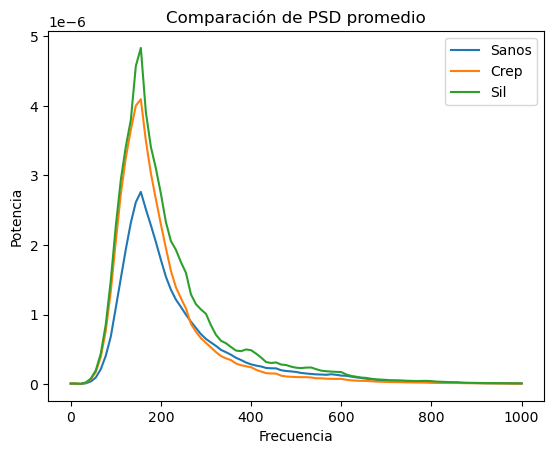

In [197]:
a=plt.figure()
prom=[welch_sanos,welch_crep,welch_sil]
new_prom=[]
f=np.linspace(0,1000,len(prom[0][0]))
for i in prom:
    new_prom.append(np.mean(i,axis=0))
for i in new_prom:
    plt.plot(f,i)
plt.title("Comparación de PSD promedio")
plt.legend(["Sanos","Crep","Sil"])
plt.ylabel("Potencia")
plt.xlabel("Frecuencia")




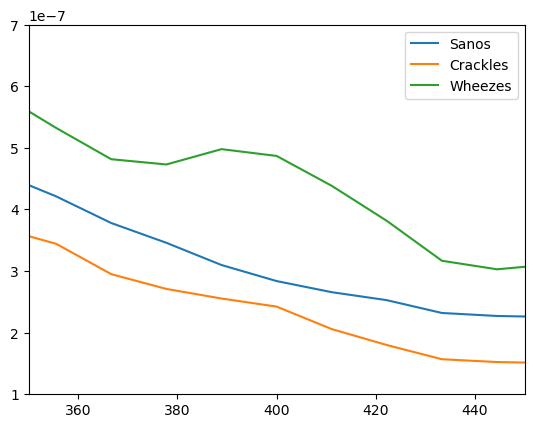

In [188]:
s.grafiquelo(new_prom,[350,450],[1e-7,7e-7])

In [17]:
sano_list,crackles_list,wheezes_list,sano_welch_list, crackles_welch_list,wheezes_welch_list=s.el_discriminador_2(datos,datos_sano,datos_crepitancia,datos_silbancia,[2000,1000],8)
winsound.Beep(freq, duration)

In [18]:
sano_list,crackles_list,wheezes_list,sano_welch_list, crackles_welch_list,wheezes_welch_list=s.el_filtrador_2([sano_list,crackles_list,wheezes_list,sano_welch_list, crackles_welch_list,wheezes_welch_list])

In [19]:
promedios=s.el_promediador(sano_welch_list, crackles_welch_list,wheezes_welch_list)

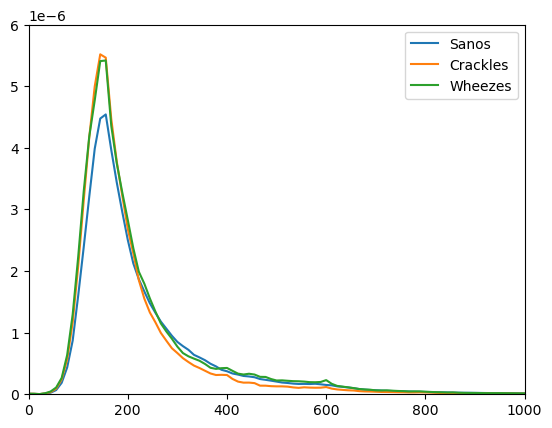

In [6]:
a=s.grafiquelo(promedios,[0,1000],[0,6e-6])

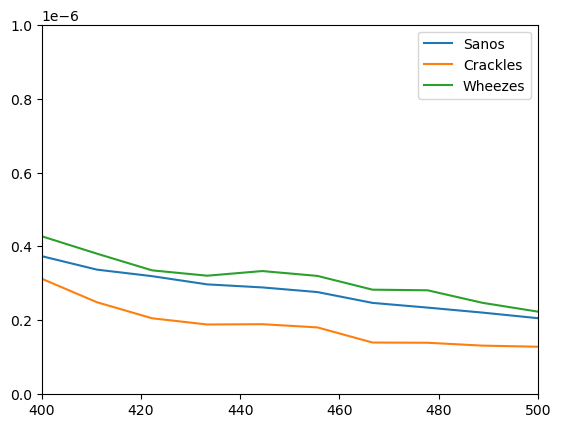

In [21]:
b=s.grafiquelo(promedios,[400,500],[0,1e-6])

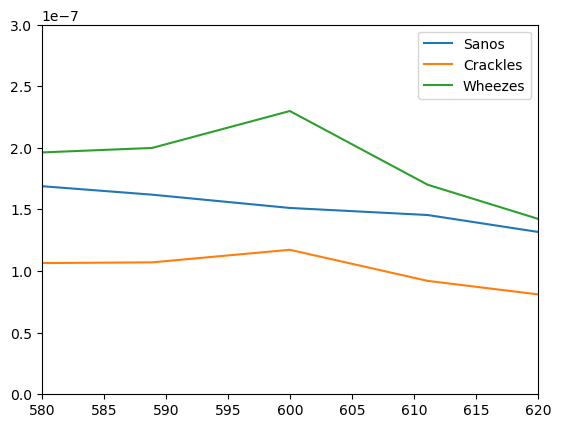

In [22]:
b=s.grafiquelo(promedios,[580,620],[0,3e-7])

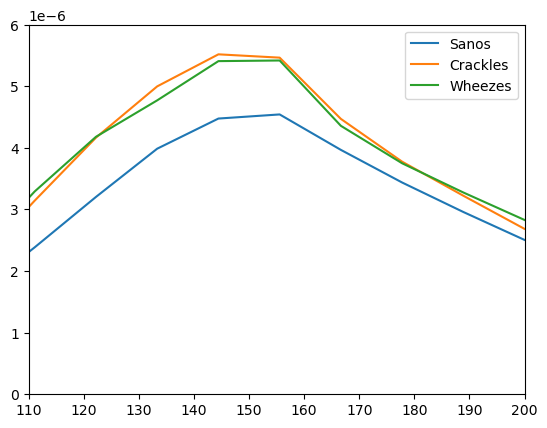

In [52]:
b=s.grafiquelo(promedios,[110,200],[0,6e-6])

In [23]:
df=pd.DataFrame( np.array(promedios))
df.to_csv("promedios.csv",index=False)

In [24]:
#!wget https://raw.githubusercontent.com/Astolfo2332/Biosenales_el_regreso/main/promedios.cvs

In [4]:
prom= np.loadtxt('promedios.csv', delimiter=',')
promedios=prom[1:]

## Rangos de comparación para la PSD

- Rango de los 3: 580 a 600 Hz
- Rango de silbancia y sanos-crepitancia 400-500 Hz

In [26]:
guelch=[sano_welch_list, crackles_welch_list,wheezes_welch_list]
listas=[sano_list,crackles_list,wheezes_list]

In [198]:
guelch=[welch_sanos,welch_crep,welch_sil]
listas=[sound_sanos,sound_crep,sound_sil]

In [27]:
d=s.el_finalizador(guelch,listas,580,600)

In [28]:
d

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,3.190663e-07,4.618627e-10,0.000003
1,Healthy,2.916347e-07,2.657086e-10,0.000003
2,Healthy,2.538778e-07,2.841734e-10,0.000003
3,Healthy,2.693581e-07,2.121868e-10,0.000003
4,Healthy,2.376131e-07,2.341438e-10,0.000003
...,...,...,...,...
5850,Wheezes,7.227610e-06,1.271946e-08,0.000083
5851,Wheezes,6.528347e-06,9.179343e-09,0.000075
5852,Wheezes,6.518463e-07,6.439959e-10,0.000008
5853,Wheezes,5.863591e-07,5.044643e-10,0.000007


In [29]:
d.to_csv("DataSet_580_600.csv",index=False)

In [30]:
d2=s.el_finalizador(guelch,listas,400,500)

In [31]:
d2

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,3.046729e-07,4.618627e-10,0.000003
1,Healthy,2.808272e-07,2.657086e-10,0.000003
2,Healthy,2.460005e-07,2.841734e-10,0.000003
3,Healthy,2.608495e-07,2.121868e-10,0.000003
4,Healthy,2.295707e-07,2.341438e-10,0.000003
...,...,...,...,...
5850,Wheezes,6.953526e-06,1.271946e-08,0.000083
5851,Wheezes,6.381584e-06,9.179343e-09,0.000075
5852,Wheezes,6.397318e-07,6.439959e-10,0.000008
5853,Wheezes,5.781082e-07,5.044643e-10,0.000007


In [32]:
d2.to_csv("DataSet_400_500.csv",index=False)

In [54]:
d3=s.el_finalizador(guelch,listas,110,200)

In [56]:
d3

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,3.179813e-08,4.618627e-10,0.000003
1,Healthy,4.598945e-08,2.657086e-10,0.000003
2,Healthy,3.002934e-08,2.841734e-10,0.000003
3,Healthy,3.846373e-08,2.121868e-10,0.000003
4,Healthy,2.763302e-08,2.341438e-10,0.000003
...,...,...,...,...
5850,Wheezes,2.869313e-07,1.271946e-08,0.000083
5851,Wheezes,3.537854e-07,9.179343e-09,0.000075
5852,Wheezes,7.677854e-08,6.439959e-10,0.000008
5853,Wheezes,5.564879e-08,5.044643e-10,0.000007


In [55]:
d3.to_csv("DataSet_110_200.csv",index=False)

In [ ]:
def el_finalizador_2():

In [199]:
d4=s.el_finalizador(guelch,listas,350,450)
d4

TypeError: object of type 'numpy.float64' has no len()